In [1]:
import pandas as pd
from file_paths_and_consts import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('classic')
import seaborn as sns
import geopandas as gpd
import random
sns.set()
import os
SEED_VALUE = 590
random.seed(SEED_VALUE)

OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/AAMAS_output_data/'

In [2]:
import multiprocessing as mp
import numpy as np
def calc_attitude_parallel(num):
    return num**2,num**3

def multiproc_attitude(all_nums):
    cpus = 4#mp.cpu_count()
    #st_time = time.time()
    hh_splits = np.array_split(all_nums, cpus) #--this a list with multiple dataframe.. each dataframe is used by one core
    #print(hh_splits)
    pool_args = [h_chunk for h_idx,h_chunk in enumerate(hh_splits)]
    #print('total time taken to split',time.time()-st_time)
    pool = mp.Pool(processes = cpus)
    results = pool.map(calc_attitude_parallel, pool_args)
    pool.close()
    pool.join()
    return results

ss = []

for i in range(0,100):
    ss.append(i)
    
results = multiproc_attitude(ss)
print(type(results[0][1]))

<class 'numpy.ndarray'>


In [3]:
pd.__version__

'1.1.0'

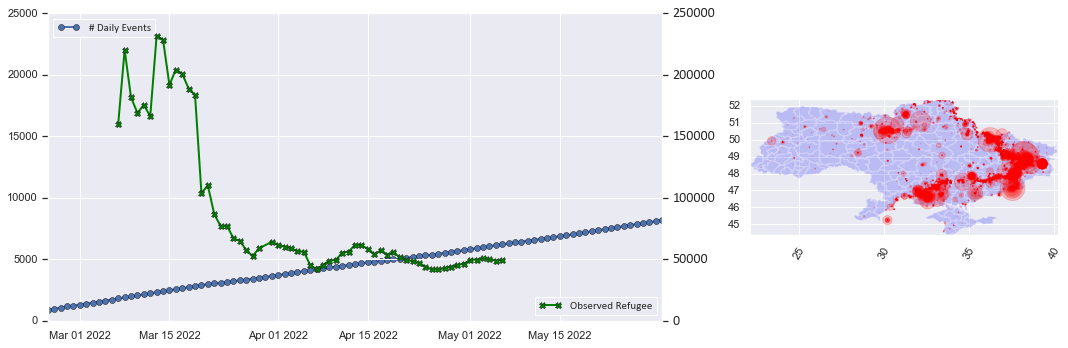

In [4]:
ROLLING = 7
conflict_data_file = UNCLEANED_DATA_DIR+'ukraine_conflict_data_feb_oct.csv'
refugee_data_file = GROUND_TRUTH_DIR+'ukraine_refugee_data_2.csv'
geo_shp_file = UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'

conflict_data = pd.read_csv(conflict_data_file)
conflict_data['time'] = pd.to_datetime(conflict_data['event_date'])
conflict_data = conflict_data.sort_values(by='time')
conflict_count = conflict_data[['time','fatalities']].groupby('time')['fatalities'].count().reset_index()
conflict_count['fatalities'] = conflict_count['fatalities'].cumsum()
conflict_count['fatalities'] = conflict_count['fatalities'].rolling(ROLLING).mean()
conflict_count = conflict_count.dropna(subset=['fatalities'])

refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.sort_values(by='time')
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])

burundi_gdf = gpd.read_file(geo_shp_file)

fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
plt.xticks(rotation=60)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 16
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14

ax2 = ax[0].twinx()
ax2.plot(refugee_data['time'],refugee_data['refugee'],marker='X',linewidth=2,color='green',label='Observed Refugee')
ax[0].plot(conflict_count['time'],conflict_count['fatalities'],marker='o',linewidth=2,label='# Daily Events')
ax[0].set_xlim([datetime.date(2022, 2, 24), datetime.date(2022, 5, 31)])
#ax.set_ylim([conflict_count['fatalities'].min()-5,conflict_count['fatalities'].max()+5])
#ax2.set_ylim([refugee_data['refugee'].min()-500,refugee_data['refugee'].max()+500])
YLIM = [0,1000]
ax[0].legend(loc='upper left')
ax2.legend(loc='lower right')
#ax[0].set_ylim(YLIM)
fig.tight_layout()

burundi_gdf.plot(ax=ax[1],color='blue',alpha=0.2)
EPS = 0.1
SCALE = 2
conflict_data_gdf = gpd.GeoDataFrame(conflict_data,geometry=gpd.points_from_xy(conflict_data.longitude,conflict_data.latitude))
conflict_data_gdf.plot(ax=ax[1],color='red',alpha=0.2,markersize=(conflict_data['fatalities']+EPS)*SCALE)
ax[1].set_xlim(burundi_gdf.total_bounds[0], burundi_gdf.total_bounds[2])
ax[1].set_ylim(burundi_gdf.total_bounds[1], burundi_gdf.total_bounds[3])
fig.tight_layout()

In [5]:
all_ids = burundi_gdf['ADM2_EN'].tolist()

In [6]:
def get_results_for_2(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 0.5,scale_2 = 2):
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            #print(cur_id,'not found')
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_raion_list(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
            all_dfs.append(cur_id)
        else:
            continue
            
    return set(all_dfs)

#get_results_for(777,prefix='mim')
def get_uncertainty_results(hyper_comb, region_name="all",prefix='fresh_calib_batch_simulation'):
    all_dfs = []
    if region_name=="all":
        col_to_sum = ['refugee','old_people','child','male','female']
        for cur_id in all_ids:
            f_name = prefix+'_result_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
            if os.path.isfile(OUTPUT_DIR+f_name):
                cur_df = pd.read_csv(OUTPUT_DIR+f_name)
                cur_df['time'] = pd.to_datetime(cur_df['time'])
                cur_df = cur_df.sort_values(by=['time','refugee'],ascending=[True,False])
                
                cur_df = cur_df.drop_duplicates(subset=['time'],keep='first')
                all_dfs.append(cur_df)
    return all_dfs

In [7]:
# ## compare if result looks same for a raion against two runs
# df1 = get_results_for_2(99950,region_name=['Kyiv'],prefix='mim_result')
# df2 = get_results_for_2(99969,region_name=['Kyiv'],prefix='mim_result')

# rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 32
# rcParams["axes.labelsize"] = 28
# rcParams["axes.titlesize"] = 28
# rcParams["xtick.labelsize"] = 26
# rcParams["ytick.labelsize"] = 26

# fig,ax = plt.subplots(figsize=(14,5))
# plt.xticks(rotation=30)

# ax.plot(df1['time'],df1['refugee'],label='99950')
# ax.plot(df2['time'],df2['refugee'],label='99960')

# ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 6)])
# ax.legend(loc='best')
# df1['refugee'].corr(df2['refugee'])


In [8]:
r1 = list(get_raion_list(20000,prefix='mim_result'))
print(len(r1))

120


In [9]:
hh_cnt = pd.read_csv('hh_cnts.csv')

## UNCERTAINTY PLOTS FOR 

#### Create the data

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('classic')
import seaborn as sns
sns.set()

def get_uncertainty(sim_indices,first_df,q1=0.25,q3=0.75):
    #first_df = first_df[0:sz]
    run_cols = [str(i) for i in sim_indices if str(i) in first_df.columns.tolist()]
    medians = first_df[run_cols].median(axis=1)
    q1 = first_df[run_cols].quantile(q1, axis=1)
    q3 = first_df[run_cols].quantile(q3, axis=1)
    return medians,q1,q3


In [11]:
import json

samples = []
with open('./logs/bayes_examples_all_log_revised.json', 'r') as file:
    for line in file:
        samples.append(json.loads(line))

good = []
max_err = -40000

for i in range(0,len(samples)):
    tt = samples[i]['target']
    if tt>max_err:
        good.append(i)
print(good)

[18, 19, 20, 21]


In [12]:
# rmse_1 = []
# rmse_2 = []



# for i in range(0,len(good)):
#     res = get_results_for_2(5000+good[i],prefix='mim_result',partition=20,scale_1=1.0,scale_2=1.0)
#     comp_df = res.merge(refugee_data,on='time',how='inner')
#     comp_df['diff'] = (comp_df['refugee_y']-comp_df['refugee_x'])**2
#     rmse = ((comp_df[5:10]['diff'].sum()+comp_df[50:55]['diff'].sum())/10)**0.5 #10 data points
#     rmse_full = ((comp_df['diff'].sum())/comp_df.shape[0])**0.5 #10 data points
#     rmse_1.append(rmse)
#     rmse_2.append(rmse_full)
#     print(good[i],rmse,rmse_full)
#     #ax.plot(rmse,rmse)


In [13]:
# %%time
# import warnings
# warnings.filterwarnings('ignore')

# #simulation_indices = [100,110,111,112,113,114]
# #simulation_indices = [115,116,117,118,119]
# #simulation_indices = [120,121,122,123,124,125,126,127,128,129,130]
# #simulation_indices = [1001,1002,1004,1009]
# #simulation_indices = [100,101,102,105]
# simulation_indices = [i for i in range(40000,40000+240)]
# #simulation_indices = [20089, 20042, 20074, 20058, 20037]
# #first_df = []
# first_df = []

# for vv in simulation_indices:
#     try:
#         print(vv,end=' ')
#         current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=40,scale_1=1.0*1.2,scale_2=2.0*1.4)
#         current_df['comb'] = str(vv)
#         #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
#         #current_df_unsmoothed['comb'] = str(vv)
#         first_df.append(current_df)
#     except:
#         continue

# first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
# #print(first_df.head())
# # mm = 1.5
# # ss = 38
# # for col in simulation_indices:
# #     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
#     #print(first_df.head())
# #second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

In [14]:
#first_df.to_csv('first_df.csv',index=False)

In [15]:
if os.path.isfile('./first_df.csv'):
    first_df = pd.read_csv('./first_df.csv')
    first_df['time'] = pd.to_datetime(first_df['time'])

In [16]:
# import warnings
# warnings.filterwarnings('ignore')

# #simulation_indices = [100,110,111,112,113,114]
# #simulation_indices = [115,116,117,118,119]
# #simulation_indices = [120,121,122,123,124,125,126,127,128,129,130]
# #simulation_indices = [1001,1002,1004,1009]
# #simulation_indices = [100,101,102,105]
# simulation_indices = [20089, 20042, 20074, 20058, 20037]
# first_df = []
# second_df = []

# for vv in simulation_indices:
#     try:
#         print(vv,end=' ')
#         current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=42,scale_1=1.0*1.2,scale_2=2.0*1.4)
#         current_df['comb'] = str(vv)
#         #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
#         #current_df_unsmoothed['comb'] = str(vv)
#         first_df.append(current_df)
#     except:
#         continue

# first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
# #print(first_df.head())
# # mm = 1.5
# # ss = 38
# # for col in simulation_indices:
# #     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
#     #print(first_df.head())
# #second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

In [17]:
refugee_data_2 = pd.read_csv('../ABM_model_Ukraine/ukr_refugee_src_2.csv')
refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
refugee_data_2 = refugee_data_2.sort_values(by='time')
refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])
#refugee_data_2 = refugee_data_2[refugee_data_2.time>pd.to_datetime('2022-05-05')]
#refugee_data_2.at[71, 'refugee'] = 49355.571429

refugee_data_2

,time,cumulative,daily,refugee
6,2022-03-02,989560,170799,141365.714286
7,2022-03-03,1173690,184130,156354.428571
8,2022-03-04,1343790,170100,166323.571429
9,2022-03-05,1540463,196673,173957.571429
10,2022-03-06,1742987,202524,178936.285714
...,...,...,...,...
90,2022-05-25,6652164,48379,46706.285714
91,2022-05-26,6700411,48247,46780.428571
92,2022-05-27,6737208,36797,44601.142857
93,2022-05-28,6771963,34755,42605.428571


In [18]:
first_df

,time,40000,40001,40002,40003,40004,40005,40006,40007,40008,...,40233,40234,40235,40236,40237,40238,40239,median,q1,q3
0,2022-03-02,198312.000000,1.631952e+05,160942.114286,1.600989e+05,1.596574e+05,1.593084e+05,159087.085714,159099.942857,158930.571429,...,175201.371429,175201.371429,180636.857143,180636.857143,185312.742857,185312.742857,189768.685714,164090.914286,163806.857143,164736.565714
1,2022-03-03,212710.285714,1.695495e+05,166710.685714,1.656857e+05,1.651442e+05,1.646566e+05,164385.600000,164357.314286,164169.942857,...,189934.628571,189934.628571,199572.514286,199572.514286,207928.800000,207928.800000,214815.771429,186912.514286,186472.971429,188162.245714
2,2022-03-04,242775.257143,1.935885e+05,190164.514286,1.890706e+05,1.883714e+05,1.877781e+05,187456.457143,187371.600000,187239.771429,...,213796.285714,213796.285714,221180.571429,221180.571429,229084.971429,229084.971429,235937.142857,190847.485714,189977.142857,193402.920000
3,2022-03-05,251848.628571,1.993054e+05,195387.771429,1.941099e+05,1.931494e+05,1.924059e+05,192061.028571,191891.142857,191688.514286,...,196347.771429,196347.771429,190370.228571,190370.228571,182974.628571,182974.628571,179642.742857,171589.714286,169629.771429,175496.468571
4,2022-03-06,242975.657143,1.826266e+05,177696.000000,1.761374e+05,1.748580e+05,1.740317e+05,173641.028571,173334.857143,173004.171429,...,166950.685714,166950.685714,170473.200000,170473.200000,174131.657143,174131.657143,180427.885714,164410.628571,161468.914286,169935.514286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2022-09-16,37.200000,3.969295e-11,0.000000,2.020378e-11,5.086674e-11,8.776624e-11,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
199,2022-09-17,51.600000,8.000000e-01,0.000000,2.020378e-11,5.086674e-11,8.776624e-11,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200,2022-09-18,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201,2022-09-19,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
# refugee_data_full = pd.read_csv('ukr_refugee_full.csv')
# refugee_data_full['refugee'] = refugee_data_full['Cumulative Refugees'].diff()
# refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
# refugee_data_full['time'] = pd.to_datetime(refugee_data_full['Date'])
# refugee_data_full = refugee_data_full.sort_values(by='time')
# refugee_data_full['refugee'] = refugee_data_full['refugee'].rolling(ROLLING).mean()
# refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
# refugee_data_full
# refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
# refugee_data_2 = refugee_data_2.sort_values(by='time')
# refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
# refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# # refugee_data['refugee'] = refugee_data['refugee'].diff()
# # refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data_2

## Local sensitivity for S

In [20]:
simulation_indices = [40000+i for i in range(40,60)]
param_name = 'S'

'40040'


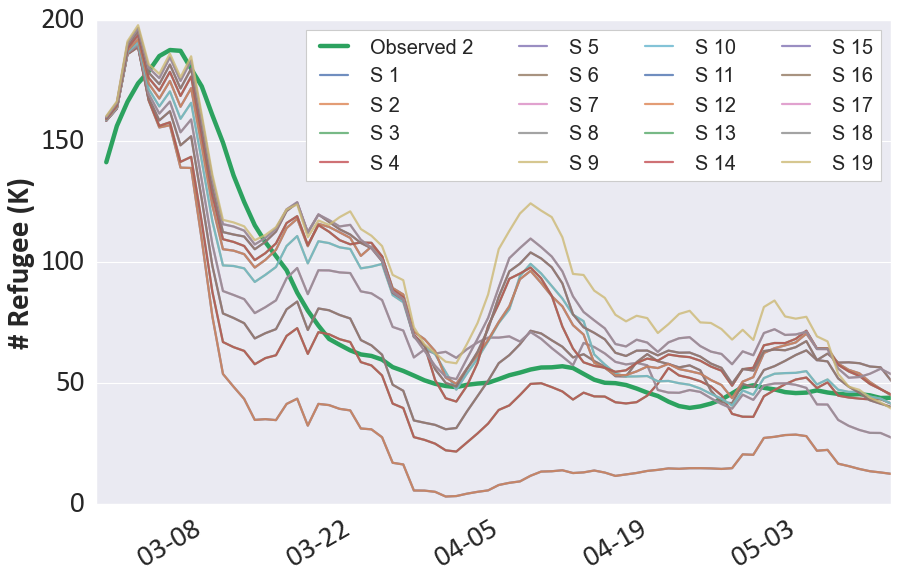

In [21]:
import datetime

trim = 7

#good = []

median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df,q1=0.35,q3=0.65)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation=30)

#ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#41ab5d')
#ax.plot(refugee_data_full['time'], refugee_data_full['refugee']/1000,label='Observed 2',linewidth=8,color='black')
ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed 2',linewidth=4,color='#2ca25f')
#l_vals = [-0.1,0.5,0.6,0.7,0.8,0.9]
#l_vals = [0.1,0.05,0.01,0.001,0.2]
#l_vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.01,0.99]
l_vals = simulation_indices
#l_vals = [0.9,0.8,0.2,0.5]
for idx,p in enumerate(simulation_indices):
    try:
        new_series = first_df[str(p)].copy()
        ax.plot(first_df['time'],new_series/1000,linewidth=2,alpha=0.8,label=param_name+" "+str(idx))
    except Exception as e:
        print(e)
        continue
sns.set_style('white')
SHIFT = -1
#ax.plot(first_df['time'][0:SHIFT],median_normal.shift(SHIFT)[0:SHIFT]/1000,linewidth=2,color='#6a51a3',alpha=1,label='ABM')
#ax.fill_between(first_df["time"][0:SHIFT], q1_normal.shift(SHIFT)[0:SHIFT]/1000, q3_normal.shift(SHIFT)[0:SHIFT]/1000, color='#9e9ac8',alpha=0.7)
#ax.plot(first_df['time'],median_normal/1000,linewidth=2,color='red',alpha=0.1,label='ABM')
#ax.fill_between(first_df["time"], q1_normal/1000, q3_normal/1000, color='red',alpha=0.1)

myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)

#ax.set_facecolor("white")
sns.set_style('whitegrid')

ax.legend(loc='best',ncol=4,fontsize=18)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 3, 1), datetime.date(2022, 5, 15)])
#ax.set_ylim([0,300])
ax.grid(axis='x')
#print(ax.get_xticks())
fig.tight_layout()
#fig.savefig('../Figures/iaai_abm_result.pdf',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo

In [22]:
first_df['median'] = median_normal.shift(SHIFT)
first_df['q1'] = q1_normal.shift(SHIFT)
first_df['q3'] = q3_normal.shift(SHIFT)
first_df = first_df[0:SHIFT]

compare_df = first_df.merge(refugee_data_2,on='time',how='inner')

## Analyze results from LHS

### first gather all the parameter space covered by LHS

In [23]:
nominal_dict = {'A': 37.060756808501864,
 'D': 2.18663941021782,
 'S': 0.5791356700688765,
 'T': 1.0348449500885029,
 'p_hi': 0.6674105660199474,
 'p_lo': 0.09264433888912414,
 'b_prob': 0.32547145503549796,
 'ps': 0.1781240295913104,
 'ews': 0.8762308137940877,
 'lambda': 0.4980495151203558,
 't_r': 6.0,
 'peer_it': 4.0}

In [24]:
dict_for_locals = {'A':['A',[40000,40020],2,nominal_dict['A'],'local_A.png'],
                   'D':['D',[40020,40040],0.1,nominal_dict['D'],'local_D.png'],
                   'S':['S',[40040,40060],1,nominal_dict['S']*100.0,'local_theta.png'],
                   'T':['T',[40060,40080],0.01,nominal_dict['T'],'local_T.png'],
                   'p_hi':['pi_hi',[40080,40100],0.1,nominal_dict['p_hi'],'local_phi.png'],
                   'p_lo':['pi_lo',[40100,40120],0.01,nominal_dict['p_lo'],'local_plo.png'],
                   'b_prob':['b_prob',[40120,40140],0.05,nominal_dict['b_prob'],'local_bprob.png'],
                  'ps':['beta_1',[40140,40160],-0.05,nominal_dict['ps'],'local_ps.png'],
                  'ews':['beta_2',[40160,40180],0.1,nominal_dict['ews'],'local_ews.png'],
                  'lambda':['lambda_1',[40180,40200],0.1,nominal_dict['lambda'],'local_lambda.png'],
                  't_r':['t_r',[40200,40220],1,nominal_dict['t_r'],'local_tr.png'],
                  'peer_it':['p_iter',[40220,40240],1,nominal_dict['peer_it'],'local_pit.png']}

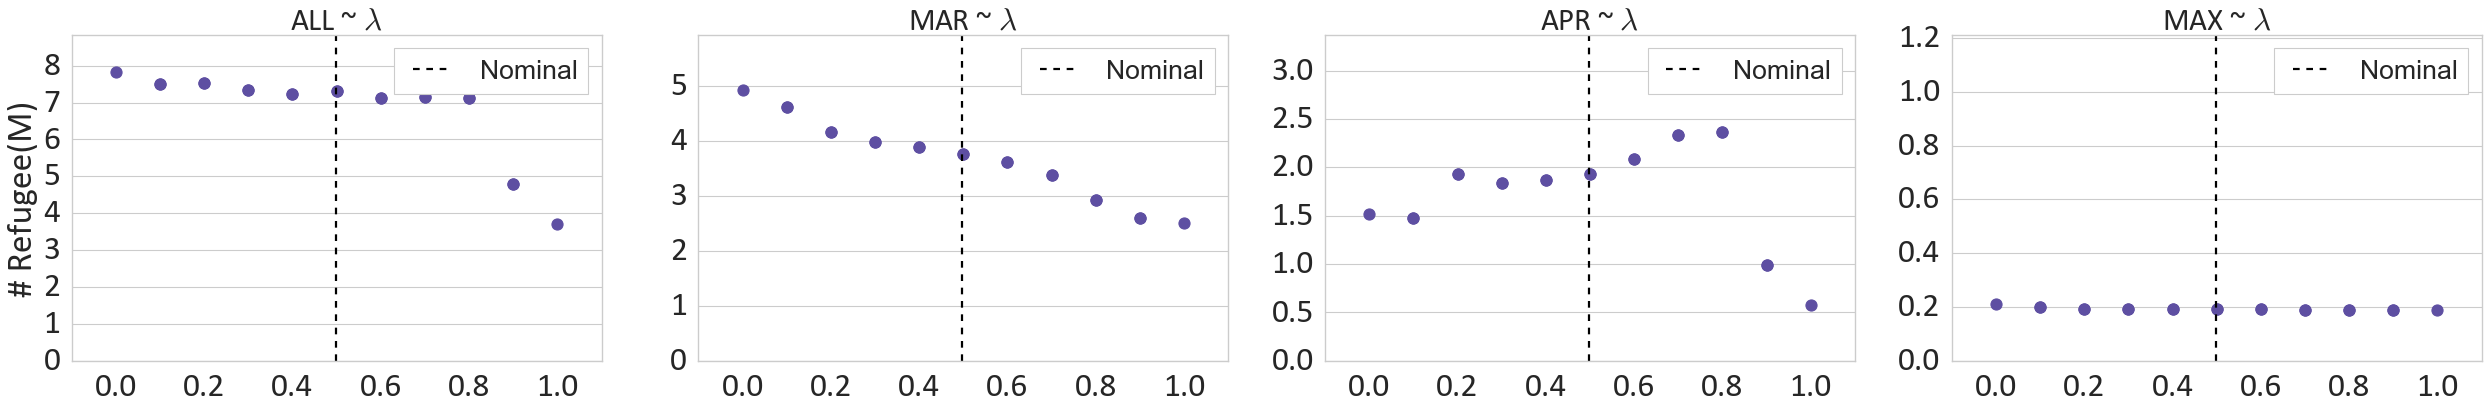

In [26]:
param_name = 'lambda'
param_name_2 = dict_for_locals[param_name][0]
simulation_ranges = dict_for_locals[param_name][1]
EPS = dict_for_locals[param_name][2]
Nominal = dict_for_locals[param_name][3]
output_file_name = dict_for_locals[param_name][4]

input_mapping = {'D':'$\\delta$','A':'Q','S':'$\\theta$','T':'$\\tau$','t_r':'$\\alpha$','beta_1':'$\\beta$','beta_2':'$\\beta2$',
                 'pi_lo':'$\\pi^{\\downarrow}$','pi_hi':'$\\pi$','lambda_1':'$\\lambda$','lambda_2':'$\\alpha$','p_iter':'Hop','b_prob':'$\\alpha$'}

output_mapping = {'output_tot':'ALL','output_MAR':'MAR','output_APR':'APR','output_MAX':'MAX'}

simulation_indices = []
def get_params_from_file(filename):
    with open(filename,'r') as f:
        line = f.readlines()[0]
        args = line.split()
        #print(args)
        param_dict = {'D':float(args[6]),'A':float(args[7]),'T':float(args[8]),'S':float(args[9]),'t_r':int(args[10]),'beta_1':float(args[12]),'beta_2':float(args[13]),
                      'pi_lo':float(args[15]),'pi_hi':float(args[16]),'lambda_1':float(args[17]),'lambda_2':1-float(args[17]),'b_prob':float(args[20]),'p_iter':int(args[25])}
    f.close()
    return param_dict


all_params = []

for i in range(simulation_ranges[0],simulation_ranges[1]):
    filename = "OFAT_SAMPLE_"+param_name+"_"+str(i)+".sh"
    param_dict = get_params_from_file(filename)
    param_dict['hyper_comb'] = i
    all_params.append(param_dict)
    simulation_indices.append(i)
    
lhs_param_df = pd.DataFrame.from_dict(all_params)
#lhs_param_df

all_outputs = []

for pp in simulation_indices:
    try:
        tot_migration = compare_df[str(pp)].sum()
        march_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))][str(pp)].sum()
        april_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))][str(pp)].sum()
        may_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-05-01')) & (compare_df.time<=pd.to_datetime('2022-05-31'))][str(pp)].sum()
        max_migration = compare_df[str(pp)].max()

        ob_tot_migration = compare_df['refugee'].sum()
        ob_march_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum()
        ob_april_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum()
        ob_may_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-05-01')) & (compare_df.time<=pd.to_datetime('2022-05-31'))]['refugee'].sum()
        ob_max_migration = compare_df[str(pp)].max()

        output_dict = {'hyper_comb':pp,'output_tot':tot_migration,'output_MAR':march_migration,'output_APR':april_migration,'output_MAY':may_migration,'output_MAX':max_migration,
                      'obs_tot':ob_tot_migration,'obs_MAR':ob_march_migration,'obs_APR':ob_april_migration,'obs_MAY':ob_may_migration,'obs_MAX':ob_max_migration}
        all_outputs.append(output_dict)
    except:
        continue
    
output_df = pd.DataFrame.from_dict(all_outputs)
#output_df

output_vs_param_df = lhs_param_df.merge(output_df,on='hyper_comb',how='inner')
#output_vs_param_df

#param_names = lhs_param_df.columns.tolist()[0:-1]
param_names = [param_name_2]
outputs_of_interest = output_df.columns.tolist()[1:6]
outputs_observed = output_df.columns.tolist()[6:11]

outputs_of_interest.remove('output_MAY')
outputs_observed.remove('obs_MAY')

# outputs_of_interest.remove('output_MAR')
# outputs_observed.remove('obs_MAR')

# outputs_of_interest.remove('output_APR')
# outputs_observed.remove('obs_APR')


import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 36
rcParams["axes.labelsize"] = 32
rcParams["axes.titlesize"] = 32
rcParams["xtick.labelsize"] = 30
rcParams["ytick.labelsize"] = 30

fig,ax = plt.subplots(len(param_names),len(outputs_of_interest),figsize=(8*len(outputs_of_interest),6*len(param_names)),squeeze=False)

sns.set_style('whitegrid')

TAKE_EVERY = 1

for i,param in enumerate(param_names):
    for j,out in enumerate(outputs_of_interest):
        ax[i][j].scatter(output_vs_param_df[output_vs_param_df.index%TAKE_EVERY==0][param],output_vs_param_df[output_vs_param_df.index%TAKE_EVERY==0][out]/1000000,s=100,color='#5e4fa2')
        ax[i][j].set_title(output_mapping[out]+' ~ '+input_mapping[param],fontsize=28)
        #ax[i][j].axhline(y=output_vs_param_df[outputs_observed[j]].mean()/1000000,color='#006837',label='Observed',linewidth=2)
        ax[i][j].axvline(x=Nominal,color='black',label='Nominal',linewidth=2,linestyle='--')
        ax[i][j].set_xlim([output_vs_param_df[output_vs_param_df.index%TAKE_EVERY==0][param].min()-EPS,output_vs_param_df[output_vs_param_df.index%TAKE_EVERY==0][param].max()+EPS])
        ax[i][j].set_ylim([0,(output_vs_param_df[out]/1000000).max()+1])
        if(j==0):
            ax[i][j].set_ylabel('# Refugee(M)')
        z = np.polyfit(output_vs_param_df[param],output_vs_param_df[out]/1000000,1)
        p = np.poly1d(z)
        #ax[i][j].plot(output_vs_param_df[param],p(output_vs_param_df[param]),"r--",label='Trend',color='#ff7f00',linewidth=2)
        ax[i][j].legend(loc='best',fontsize=24,ncol=1)
        ax[i][j].yaxis.grid(True)
        ax[i][j].xaxis.grid(False)
        
fig.tight_layout()
#fig.savefig('../Figures/'+'aamas_appendix_full_'+output_file_name,bbox_inches='tight',dpi=350)

In [65]:
output_vs_param_df.columns.tolist()

['D',
 'A',
 'T',
 'S',
 't_r',
 'beta_1',
 'beta_2',
 'pi_lo',
 'pi_hi',
 'lambda_1',
 'lambda_2',
 'b_prob',
 'p_iter',
 'hyper_comb',
 'output_tot',
 'output_MAR',
 'output_APR',
 'output_MAY',
 'output_MAX',
 'obs_tot',
 'obs_MAR',
 'obs_APR',
 'obs_MAY',
 'obs_MAX']

### gather outputs of interest for each parameter space
### outputs of interest: total migration, migration in march, migration in april, migration in may, max migration one day

In [46]:
all_outputs = []

for pp in simulation_indices:
    try:
        tot_migration = compare_df[str(pp)].sum()
        march_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))][str(pp)].sum()
        april_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))][str(pp)].sum()
        may_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-05-01')) & (compare_df.time<=pd.to_datetime('2022-05-31'))][str(pp)].sum()
        max_migration = compare_df[str(pp)].max()

        ob_tot_migration = compare_df['refugee'].sum()
        ob_march_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum()
        ob_april_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum()
        ob_may_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-05-01')) & (compare_df.time<=pd.to_datetime('2022-05-31'))]['refugee'].sum()
        ob_max_migration = compare_df[str(pp)].max()

        output_dict = {'hyper_comb':pp,'output_tot':tot_migration,'output_MAR':march_migration,'output_APR':april_migration,'output_MAY':may_migration,'output_MAX':max_migration,
                      'obs_tot':ob_tot_migration,'obs_MAR':ob_march_migration,'obs_APR':ob_april_migration,'obs_MAY':ob_may_migration,'obs_MAX':ob_max_migration}
        all_outputs.append(output_dict)
    except:
        continue
    
output_df = pd.DataFrame.from_dict(all_outputs)
#output_df

## merge the two dataframes for sensitivity analysis

In [47]:
output_vs_param_df = lhs_param_df.merge(output_df,on='hyper_comb',how='inner')
#output_vs_param_df

In [48]:
#output_vs_param_df

,D,A,T,S,t_r,beta_1,beta_2,pi_lo,pi_hi,lambda_1,...,output_tot,output_MAR,output_APR,output_MAY,output_MAX,obs_tot,obs_MAR,obs_APR,obs_MAY,obs_MAX
0,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.3,0.49805,...,8.330287e+06,5.426135e+06,1.683313e+06,1220838.0,294325.200000,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,294325.200000
1,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.3,0.49805,...,8.330287e+06,5.426135e+06,1.683313e+06,1220838.0,294325.200000,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,294325.200000
2,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.4,0.49805,...,7.786246e+06,4.090759e+06,2.080836e+06,1614650.4,194401.714286,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,194401.714286
3,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.4,0.49805,...,7.786246e+06,4.090759e+06,2.080836e+06,1614650.4,194401.714286,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,194401.714286
4,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.4,0.49805,...,7.786246e+06,4.090759e+06,2.080836e+06,1614650.4,194401.714286,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,194401.714286
5,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.5,0.49805,...,7.306464e+06,3.762203e+06,1.934196e+06,1610064.8,191803.371429,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,191803.371429
6,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.5,0.49805,...,7.306464e+06,3.762203e+06,1.934196e+06,1610064.8,191803.371429,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,191803.371429
7,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.6,0.49805,...,7.306464e+06,3.762203e+06,1.934196e+06,1610064.8,191803.371429,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,191803.371429
8,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.6,0.49805,...,7.306464e+06,3.762203e+06,1.934196e+06,1610064.8,191803.371429,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,191803.371429
9,2.186639,37.060757,1.034845,57.913567,6,0.178124,0.876231,0.092644,0.6,0.49805,...,7.306464e+06,3.762203e+06,1.934196e+06,1610064.8,191803.371429,6.325947e+06,3.511471e+06,1.477772e+06,1.336703e+06,191803.371429


In [49]:
#param_names = lhs_param_df.columns.tolist()[0:-1]
param_names = ['pi_hi']
outputs_of_interest = output_df.columns.tolist()[1:6]
outputs_observed = output_df.columns.tolist()[6:11]
outputs_of_interest.remove('output_MAY')
outputs_observed.remove('obs_MAY')

## create scatter plot for each output of interest and each single parameter

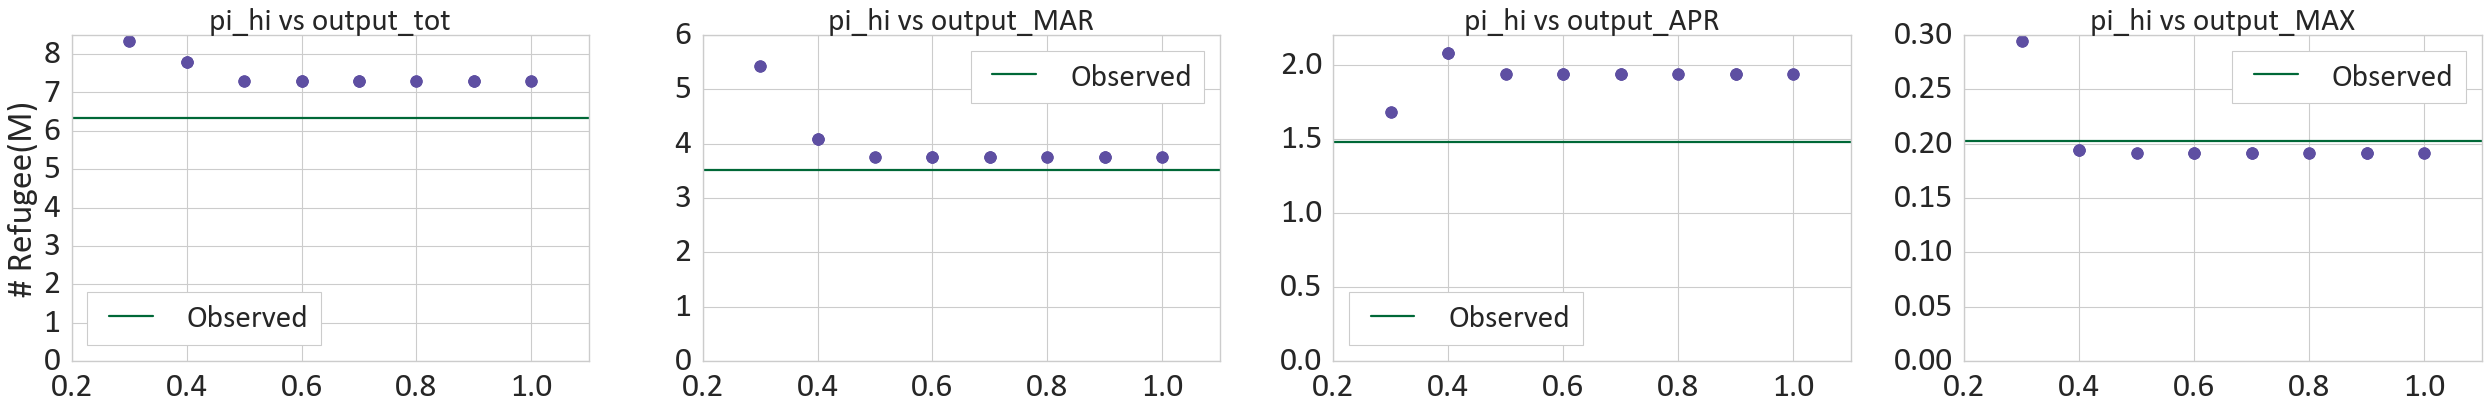

In [51]:
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 36
rcParams["axes.labelsize"] = 32
rcParams["axes.titlesize"] = 32
rcParams["xtick.labelsize"] = 30
rcParams["ytick.labelsize"] = 30

fig,ax = plt.subplots(len(param_names),len(outputs_of_interest),figsize=(8*len(outputs_of_interest),6*len(param_names)),squeeze=False)

EPS = 0.1

for i,param in enumerate(param_names):
    for j,out in enumerate(outputs_of_interest):
        ax[i][j].scatter(output_vs_param_df[param],output_vs_param_df[out]/1000000,s=100,color='#5e4fa2')
        ax[i][j].set_title(param+' vs '+out,fontsize=28)
        ax[i][j].axhline(y=output_vs_param_df[outputs_observed[j]].mean()/1000000,color='#006837',label='Observed',linewidth=2)
        ax[i][j].set_xlim([output_vs_param_df[param].min()-EPS,output_vs_param_df[param].max()+EPS])
        ax[i][j].set_ylim([0,None])
        if(j==0):
            ax[i][j].set_ylabel('# Refugee(M)')
        z = np.polyfit(output_vs_param_df[param],output_vs_param_df[out]/1000000,1)
        p = np.poly1d(z)
        #ax[i][j].plot(output_vs_param_df[param],p(output_vs_param_df[param]),"r--",label='Trend',color='#ff7f00',linewidth=2)
        ax[i][j].legend(loc='best',fontsize=28,ncol=2)
fig.tight_layout()

In [116]:
import pingouin as pg

for output in outputs_of_interest:
    for param in param_names:
        covs = [p for p in param_names if p!=param]
        #print(param,output)
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs).round(20)
        #print(covs)
        if cur_df_pearson['p-val'].mean()<0.05:
            print('Pearson',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
        
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs,method='spearman').round(7)
        #print(covs)
        if cur_df_pearson['p-val'].mean()<0.05:
            print('Spearman',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
        print('')


Spearman A output_tot r= -0.2345949 CI95%= [-0.42 -0.03] p-val= 0.0278049


Pearson S output_tot r= 0.5585288021441495 CI95%= [0.4  0.69] p-val= 1.561831948781e-08
Spearman S output_tot r= 0.7274099 CI95%= [0.61 0.81] p-val= 0.0


Pearson beta_1 output_tot r= 0.26133170455731053 CI95%= [0.05 0.45] p-val= 0.013918654075791587
Spearman beta_1 output_tot r= 0.3395922 CI95%= [0.14 0.51] p-val= 0.0012085



Spearman pi_hi output_tot r= -0.2595282 CI95%= [-0.44 -0.05] p-val= 0.0146152

Pearson lambda_1 output_tot r= -0.463283542550398 CI95%= [-0.61 -0.28] p-val= 5.48559536139513e-06
Spearman lambda_1 output_tot r= -0.6068695 CI95%= [-0.72 -0.46] p-val= 0.0

Pearson lambda_2 output_tot r= 0.4632835425504226 CI95%= [0.28 0.61] p-val= 5.48559536138801e-06
Spearman lambda_2 output_tot r= 0.6068695 CI95%= [0.46 0.72] p-val= 0.0

Pearson b_prob output_tot r= -0.27893822218187586 CI95%= [-0.46 -0.07] p-val= 0.00849556367604297
Spearman b_prob output_tot r= 0.8804806 CI95%= [0.82 0.92] p-val= 0.0



In [108]:
print(pg.partial_corr(data=df, x='x', y='y', covar='cv1').round(1))

          n    r         CI95%  p-val
pearson  30  0.6  [0.25, 0.77]    0.0


In [101]:
pg.partial_corr(data=df, x='x', y='y', covar='cv1').round(2)

,n,r,CI95%,p-val
pearson,30,0.57,"[0.25, 0.77]",0.0


In [107]:
pg.partial_corr(data=df, x='x', y='y', covar=['y','cv2','cv3']).round(10)

,n,r,CI95%,p-val
pearson,30,-0.094767,"[-0.46, 0.3]",0.638226


In [156]:
sum(all_mses)/len(all_mses)

26000.035190333296

In [157]:
np.std(all_mses)

1301.9169308224493

In [ ]:
(compare_df['median']-compare_df['refugee'])

In [61]:
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q3'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q3'].sum()
compare_df['q1'].sum()
compare_df['q3'].sum()

3400824.6428571427

## Compare with food prices

In [73]:
# food_df = pd.read_csv(UNCLEANED_DATA_DIR+'wfp_food_prices_ukr.csv')
# #food_df['commodity'].unique().tolist()
# food_df['date'] = pd.to_datetime(food_df['date'])

# for food in food_df['commodity'].unique().tolist():
#     cur_food_price = food_df[food_df.commodity==food]
    

## compare_everything

In [75]:
x = 7275283.098597599
y = 5523150.002945037
z = 1616600.5681473766
a = 10305552.99151849
b = 7887347.678246012
c = 2202283.6001177765

In [76]:
x_axis = ['Overall','March','April']
Method = ['Observed','ABM','Pandey']
colors = ['#41ab5d','#6a51a3','#ae017e']
values = [[5160175,3321159,1540624],[4917812,3400824,1266664],[8519858,6484278,1881154]]
errmin = [[0,0,0],[values[1][0]-3990658,values[1][1]-2878165,values[1][2]-907943],[values[2][0]-x,values[2][1]-y,values[2][2]-z]]
errmax = [[0,0,0],[6137919-values[1][0],4123093-values[1][1],1711786-values[1][2]],[a-values[2][0],b-values[2][1],c-values[2][2]]]

In [77]:
print(errmin)
print(errmax)

[[0, 0, 0], [927154, 522659, 358721], [1244574.9014024008, 961127.9970549634, 264553.43185262335]]
[[0, 0, 0], [1220107, 722269, 445122], [1785694.99151849, 1403069.678246012, 321129.60011777654]]


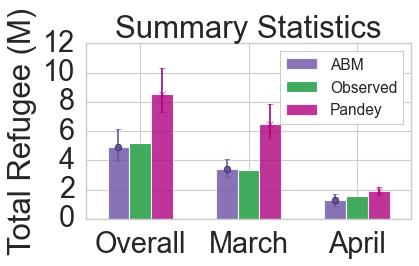

In [105]:
# Numbers of pairs of bars you want
N = len(x_axis)

truth_bar = values[0]
abm_bar = values[1]
pandey_bar = values[2]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
fig,ax = plt.subplots(figsize=(6,4))

# Width of a bar 
width = 0.2       

# Plotting
ax.bar(ind - width, np.array(abm_bar)/1e6 , width, label='ABM',color=colors[1],alpha=0.8)
ax.errorbar(ind - width, np.array(abm_bar)/1e6, yerr = [np.array(errmin[1])/1e6,np.array(errmax[1])/1e6],fmt='o',color=colors[1])

ax.bar(ind, np.array(truth_bar)/1e6 , width, label='Observed',color=colors[0])

ax.bar(ind + width, np.array(pandey_bar)/1e6 , width, label='Pandey',color=colors[2],alpha=0.8)
ax.errorbar(ind + width, np.array(pandey_bar)/1e6, yerr = [np.array(errmin[2])/1e6,np.array(errmax[2])/1e6],fmt='x',color=colors[2])

ax.set_ylabel('Total Refugee (M)')

ax.set_title('Summary Statistics')

ax.set_xticks(ind)
ax.set_xticklabels(x_axis)
ax.set_yticks
# Finding the best position for legends and putting it
ax.legend(loc='best',fontsize=14,ncol=1)
ax.set_ylim([0,12])
fig.tight_layout()
fig.savefig('../Figures/summary_stat.pdf',dpi=350,bbox_inches='tight')

In [93]:
[errmin[1],errmax[1]]

[[927154, 522659, 358721], [1220107, 722269, 445122]]

In [81]:
np.array(abm_bar)/1e6

array([4.917812, 3.400824, 1.266664])

In [51]:
all_dfs = []
for region in all_ids:
    print(region,end=' ')
    try:
        cur_df = get_results_for_2(5000+101, who='refugee',region_name=[region],prefix='mim_result',partition = 20,scale_1 = 1.2,scale_2 = 1.5)
        cur_df['raion'] = region
        all_dfs.append(cur_df)
        #break
    except:
        print('chesta')
        continue

Bakhchysaraiskyi 1 raions found
Bilohirskyi 1 raions found
Dzhankoiskyi 1 raions found
Yevpatoriiskyi 1 raions found
Kerchynskyi 1 raions found
Krasnohvardiiskyi chesta
Krasnoperekopskyi chesta
Simferopolskyi 1 raions found
Feodosiiskyi 1 raions found
Yaltynskyi chesta
Vinnytskyi 1 raions found
Haisynskyi chesta
Zhmerynskyi 1 raions found
Mohyliv-Podilskyi chesta
Tulchynskyi chesta
Khmilnytskyi 1 raions found
Volodymyrskyi 1 raions found
Kamin-Kashyrskyi 1 raions found
Kovelskyi chesta
Lutskyi 1 raions found
Dniprovskyi 1 raions found
Kamianskyi 1 raions found
Kryvorizkyi 1 raions found
Nikopolskyi 1 raions found
Novomoskovskyi 1 raions found
Pavlohradskyi 1 raions found
Synelnykivskyi 1 raions found
Bakhmutskyi 1 raions found
Volnovaskyi 1 raions found
Horlivskyi 1 raions found
Donetskyi 1 raions found
Kalmiuskyi 1 raions found
Kramatorskyi 1 raions found
Mariupolskyi 1 raions found
Pokrovskyi 1 raions found
Berdychivskyi 1 raions found
Zhytomyrskyi 1 raions found
Korostenskyi 1 raion

In [53]:
pivot_df = pd.concat(all_dfs).pivot(index='raion',columns='time',values='refugee')
each_day_max_raion = pivot_df.idxmax().reset_index()

In [55]:
each_day_max_raion[0].value_counts()

Zaporizkyi      32
Kramatorskyi    12
Alchevskyi       8
Kyiv             8
Kryvorizkyi      8
Chuhuivskyi      7
Kharkivskyi      7
Mykolaivskyi     5
Khersonskyi      5
Donetskyi        2
Name: 0, dtype: int64

In [99]:
def assign_raion_to_dest(hyper_comb, raion, who='refugee',prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 1.2,scale_2 = 1.5):
    all_dfs = []
    f_name = prefix+'_completed_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    f2_name = prefix+'_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    #print(f_name)
    if os.path.isfile(OUTPUT_DIR+f_name):
        true_f_name = f_name
    elif os.path.isfile(OUTPUT_DIR+f2_name):
        true_f_name = f2_name

    cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
    cur_df['time'] = pd.to_datetime(cur_df['time'])
    all_dfs.append(cur_df)
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(ovr_df[who].sum(),end=' ')
    #dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_stock_only_'+str(raion)+'.csv')
    dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_stock_only_eu_only_'+str(raion)+'.csv')
    ovr_df['key'] = 1
    dest_df['key'] = 1
    raion_to_dest = ovr_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
    raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
    print(raion_to_dest['flow'].sum(),raion)
    raion_to_dest['from'] = raion
    return raion_to_dest

In [100]:
all_dests = []

for raion in all_ids:
    try:
        dest_raion_df = assign_raion_to_dest(5000+101,raion,prefix='mim_result')
        all_dests.append(dest_raion_df)
    except:
        continue

1337.485714285715 1337.485714285715 Bakhchysaraiskyi
26.4 26.4 Bilohirskyi
150.9 150.9 Dzhankoiskyi
165.59999999999997 165.59999999999997 Yevpatoriiskyi
277.5 277.5 Kerchynskyi
3431.0999999999995 3431.1 Simferopolskyi
120.0 120.0 Feodosiiskyi
16826.571428571435 16826.571428571428 Vinnytskyi
1351.5 1351.4999999999998 Zhmerynskyi
328.5 328.49999999999994 Khmilnytskyi
152.4 152.39999999999998 Volodymyrskyi
10.799999999999999 10.799999999999997 Kamin-Kashyrskyi
6888.3 6888.3 Lutskyi
63215.74285714286 63215.74285714286 Dniprovskyi
265.2 265.2 Kamianskyi
375983.9142857143 375983.91428571433 Kryvorizkyi
18583.842857142852 18583.842857142856 Nikopolskyi
477.0 477.0 Novomoskovskyi
3105.814285714286 3105.8142857142866 Pavlohradskyi
1775.0571428571427 1775.057142857143 Synelnykivskyi
68638.28571428574 68638.28571428575 Bakhmutskyi
72995.87142857142 72995.87142857145 Volnovaskyi
263723.3999999996 263723.3999999997 Horlivskyi
505756.41428571334 505756.41428571334 Donetskyi
63817.45714285707 63817.4

In [101]:
all_flow_from_all_raion = pd.concat(all_dests)
all_flow_from_all_raion.groupby('Country')['flow'].sum().reset_index().sort_values(by='flow',ascending=False)

,Country,flow
19,Poland,1.950578e+06
14,Italy,9.055663e+05
10,Germany,7.335411e+05
5,Czech Republic,5.643315e+05
12,Hungary,3.730222e+05
21,Romania,3.225132e+05
24,Spain,2.221435e+05
11,Greece,1.927058e+05
7,Estonia,1.826178e+05
2,Bulgaria,1.458914e+05


In [85]:
raion_df = get_results_for_2(5000+101,region_name=['Kyiv'],prefix='mim_result')
print(raion_df['refugee'].sum())
dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_'+str('Kyiv')+'.csv')
dest_df['rij'].sum()
raion_df['key'] = 1
dest_df['key'] = 1
raion_to_dest = raion_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
print(raion_to_dest['flow'].sum())

1 raions found
358943.28571428574
357090.9346861782
